## Experiment Setup

###  Random seed / PyTorch / Colab / CUDA related

In [1]:
import time
import datetime
import importlib
import os

import torch

import numpy as np
import matplotlib.pyplot as plt

# pyplot setting
%matplotlib inline

# Use Google Colab
use_colab = True

# Is this running on Colab?
colab_available = importlib.util.find_spec("google.colab") is not None

if use_colab and colab_available:
    # Mount my Google Drive root folder
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Pyro
    !pip install pyro-ppl

    # cd to bayesian-dl-experiments directory
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    !ls

# This needs to be imported after we are done with Colab setting
import pyro

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor') 
    torch.backends.cudnn.deterministic = True
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory=True # Faster Host to GPU copies with page-locked memory
else:
    torch_device = torch.device('cpu')
    use_pin_memory=False

### Variable settings

In [2]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""
# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

# Dropout rate
dropout_rate = 0.5

# L2 regularization strength
reg_strength = 0.3

# Epochs
n_epochs = 400

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 100

In [3]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    test_start_time + '_' + str(n_epochs) + '_' + str(dropout_rate) + '_' + str(reg_strength) + '_' + str(loss_function_type) + '_' + str(n_predictions)
)

os.makedirs(test_results_path)

## Prepare data

### Get the data as a torch Dataset object

In [4]:
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets

dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Print the size of the dataset
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Define network

In [5]:
from ronald_bdl import models

uncertainty_methods = {}

# MC (Bernoulli) dropout
uncertainty_methods['mc_dropout'] = models.FCNetMCDropout(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    dropout_rate=dropout_rate,
    dropout_type='bernoulli',
)

# Vanilla Variational Inference
uncertainty_methods['variational_inference'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
   output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
)

# HMC (NUTS)
uncertainty_methods['hmc'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
)

## Train the network

### Train/test the model

In [6]:
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, NUTS, MCMC

for key, network in uncertainty_methods.items():
    
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    train_loader = DataLoader(dataset, batch_size=len(dataset))
    
    # Optimizer setup
    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=0.01,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        if key == 'variational_inference':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network.model, network.guide, optimizer, loss=Trace_ELBO(), num_samples=1000)
        elif key == 'hmc':
            nuts_kernel = NUTS(network.model)
            mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=100)
            
        pyro.clear_param_store()
    
    """
    Training
    """
    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        dataset.data_x.to(torch_device)
        dataset.data_y.to(torch_device)
        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNetMCDropout):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    if loss_function_type == 'test_ll_mc':
                        _, _, _, metrics = network.predict_dist(
                            inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

                        total_loss = -(metrics['test_ll_mc'])
                    
                    else:
                        total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNetMCDropout(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)

[iteration 0001] loss: 613.9195
[iteration 0101] loss: 157.4110
[iteration 0201] loss: 148.9222
[iteration 0301] loss: 111.6623
final loss = tensor(100.3918, grad_fn=<MseLossBackward>)
training time = 1.1949479579925537 seconds

Now running variational_inference
FCNetPyro(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Identity()
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)

[iteration 0001] loss: nan


/Users/se9/python/00_default/lib/python3.6/site-packages/pyro/infer/trace_elbo.py:135: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


[iteration 0101] loss: nan
[iteration 0201] loss: nan
[iteration 0301] loss: nan


Warmup:   0%|          | 1/2100 [00:00,  6.14it/s, step size=3.60e+00, acc. prob=1.000]

final loss = nan
training time = 4.277322053909302 seconds

Now running hmc
FCNetPyro(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Identity()
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)



sample: 100%|██████████| 2100/2100 [02:51, 12.25it/s, step size=2.93e-01, acc. prob=0.891]

final loss = nan
training time = 171.42840099334717 seconds



testing time = 4.386714220046997 seconds

Mean = tensor([-41.6790, -40.6880, -39.5574, -38.0876, -36.9174, -35.9321, -34.7288,
        -33.5449, -32.2705, -31.2464, -30.0208, -28.7263, -27.6148, -26.4410,
        -25.2391, -24.0645, -22.8422, -21.7105, -20.5451, -19.2720, -18.1174,
        -16.8988, -15.7213, -14.5108, -13.2956, -12.1445, -10.9657,  -9.8707,
         -8.7893,  -7.7026,  -6.7083,  -5.8339,  -5.0284,  -4.3079,  -3.6619,
         -3.0807,  -2.5272,  -2.0077,  -1.5295,  -1.1078,  -0.7415,  -0.4795,
         -0.2429,  -0.0615,   0.0884,   0.2391,   0.3908,   0.4994,   0.5992,
          0.7284,   0.8652,   1.0141,   1.1621,   1.3465,   1.5376,   1.7479,
          1.9667,   2.1645,   2.3962,   2.6504,   2.8912,   3.1391,   3.3794,
          3.6146,   3.8766,   4.1539,   4.4322,   4.7271,   5.1464,   5.5640,
          6.0921,   6.6634,   7.2814,   7.9555,   8.9782,  10.1944,  11.6007,
         13.0741,  14.5861,  16.0878,  17.5817,  19.1508,  20.5990,  21.9954,
         23.568

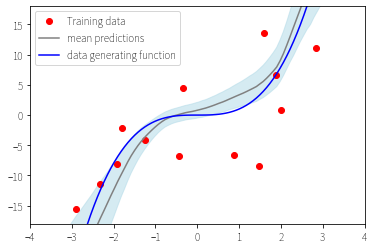

testing time = 15.764600038528442 seconds

Mean = tensor([28.2756, 27.6969, 27.1184, 26.5398, 25.9611, 25.3819, 24.7942, 24.2064,
        23.6186, 23.0309, 22.4431, 21.8554, 21.2676, 20.6798, 20.0921, 19.5043,
        18.9166, 18.3288, 17.7411, 17.1533, 16.5922, 16.0356, 15.4739, 14.9247,
        14.3790, 13.8334, 13.2910, 12.7607, 12.2332, 11.6917, 11.0835, 10.4753,
         9.8015,  9.1177,  8.4090,  7.6983,  7.0793,  6.4763,  5.9300,  5.4647,
         5.0320,  4.5370,  4.0222,  3.5074,  3.0211,  2.6330,  2.2340,  1.8388,
         1.5677,  1.3471,  1.1172,  0.8546,  0.5345,  0.2254, -0.1652, -0.6115,
        -1.0577, -1.5471, -1.8936, -2.2227, -2.4155, -2.5026, -2.6311, -2.7576,
        -2.8840, -3.0114, -3.1695, -3.3549, -3.5384, -3.7219, -3.9054, -4.0889,
        -4.2806, -4.4731, -4.6421, -4.8000, -4.9508, -5.0872, -5.2236, -5.3599,
        -5.5430, -5.7610, -5.9842, -6.1916, -6.3727, -6.5539, -6.7326, -6.9054,
        -7.0755, -7.2430, -7.4105, -7.5781, -7.7503, -7.9238, -8.0973,

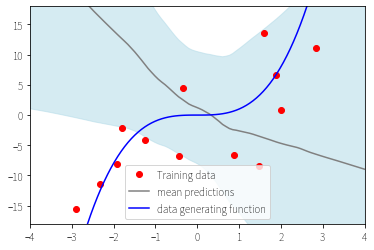

testing time = 16.078202962875366 seconds

Mean = tensor([28.4617, 27.8798, 27.2979, 26.7159, 26.1340, 25.5514, 24.9596, 24.3679,
        23.7761, 23.1842, 22.5925, 22.0007, 21.4089, 20.8170, 20.2253, 19.6334,
        19.0417, 18.4498, 17.8581, 17.2662, 16.7018, 16.1422, 15.5775, 15.0246,
        14.4750, 13.9253, 13.3787, 12.8441, 12.3123, 11.7666, 11.1531, 10.5395,
         9.8606,  9.1715,  8.4569,  7.7404,  7.1157,  6.5075,  5.9565,  5.4869,
         5.0499,  4.5487,  4.0271,  3.5055,  3.0123,  2.6168,  2.2134,  1.8145,
         1.5397,  1.3149,  1.0800,  0.8109,  0.4848,  0.1712, -0.2234, -0.6736,
        -1.1238, -1.6170, -1.9654, -2.2962, -2.4911, -2.5810, -2.7120, -2.8391,
        -2.9663, -3.0945, -3.2541, -3.4410, -3.6261, -3.8112, -3.9963, -4.1814,
        -4.3746, -4.5683, -4.7382, -4.8970, -5.0486, -5.1856, -5.3227, -5.4597,
        -5.6436, -5.8628, -6.0873, -6.2960, -6.4785, -6.6611, -6.8413, -7.0155,
        -7.1872, -7.3566, -7.5259, -7.6953, -7.8692, -8.0444, -8.2196,

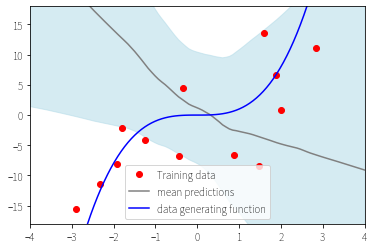

In [7]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()    
    
    predictions, mean, var, metrics = network.predict_dist(X_test, 10000)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")
    
    """
    Print results
    """
    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(X_test.flatten(), (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(), (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
                     color='lightblue', alpha=0.5)

    # Train data
    plt.plot(dataset.data_x, dataset.data_y, 'or', label='Training data')

    # MC prediction
    plt.plot(X_test, mean.detach().numpy(), 'gray', label='mean predictions')
    
    # Original data generating function without noise
    plt.plot(X_test, X_test ** 3, 'blue', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'))
    
    plt.show()